In [16]:
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold


from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier, XGBRFClassifier

sys.path.append("../../")

from helpers.split import make_train_test_split, tag_label_feature_split
from helpers.assess import make_classification_report, make_confusion_matrix

DATASET_FOLDER = "../../datasets/"

In [108]:
# read a data set
df = pd.read_pickle(DATASET_FOLDER + "dataset_01_mean.pickle")

In [109]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded", samples_per_genre=350)

In [110]:
pd.Series(y).value_counts()

7    350
9    350
1    350
8    350
0    350
4    350
6    350
5    350
2    350
3    350
dtype: int64

In [111]:
# review the shapes
print(f"{X.shape= } {y.shape= }")

X.shape= (3500, 13) y.shape= (3500,)


In [112]:
# split the data for training and testing with shuffling and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1962, shuffle=True, stratify=y
)

In [113]:
# review the shapes
print(f"{X_train.shape = }\t{y_train.shape = }")
print(f"{X_test.shape =  }\t{y_test.shape =  }")

X_train.shape = (2800, 13)	y_train.shape = (2800,)
X_test.shape =  (700, 13)	y_test.shape =  (700,)


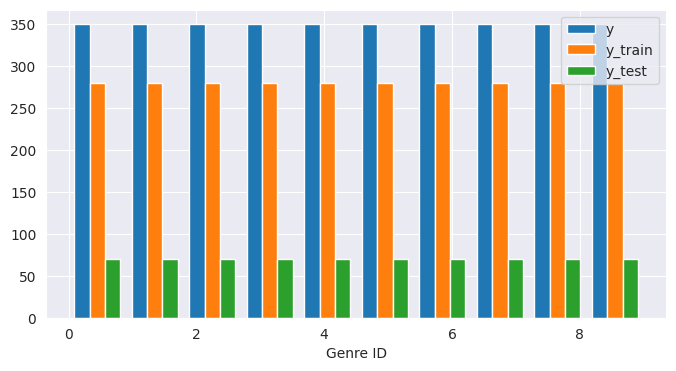

In [114]:
plt.figure(figsize=(8,4))
plt.hist([y, y_train, y_test],
         label=['y', 'y_train', 'y_test'])
plt.xlabel("Genre ID")
plt.legend()
plt.show()

In [115]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca=PCA(random_state=1962, n_components=.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [124]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1962)

classifiers = []

for train_idx, validate_idx in skf.split(X_train, y_train):
    X_fold_train, X_fold_validate = X_train_scaled[train_idx], X_train_scaled[validate_idx]
    y_fold_train, y_fold_validate = y[train_idx], y[validate_idx]
    
#    smt = SMOTETomek(random_state=1962, n_jobs=-1)
#    smt = SMOTE(random_state=1962, n_jobs=--1)
    
    print ("resample")
#    X_fold_train_resampled, y_fold_train_resampled = smt.fit_resample(X_fold_train, y_fold_train)

    X_fold_train_resampled = X_fold_train
    y_fold_train_resampled = y_fold_train
    
    print ("create classifier")
    classifier = XGBClassifier(
#        learning_rate=.221461,
#        n_estimators=827,
#        max_depth=4,
#        gamma=.524969,
#        reg_alpha=4.327827,
        use_label_encoder=False,
        tree_method="gpu_hist",
        sampling_method="gradient_based",
        objective="multi:softprob",
        eval_metric=["mlogloss", "auc"], 
        early_stopping_rounds=10,
        seed=1962,
    )

    eval_set = [(X_fold_train_resampled, y_fold_train_resampled), (X_fold_validate, y_fold_validate)]
    classifier.fit(X_fold_train_resampled, y_fold_train_resampled,
                   
                   eval_set=eval_set, 
                   verbose=False)
    
    classifiers.append(classifier)
    

resample
create classifier
resample
create classifier
resample
create classifier
resample
create classifier
resample
create classifier


In [125]:
test_model = classifiers[4]
test_model_results = test_model.evals_result()
for key, val in test_model_results.items():
    print(key)

validation_0
validation_1


In [126]:
train_results=test_model_results['validation_0']
test_results=test_model_results['validation_1']

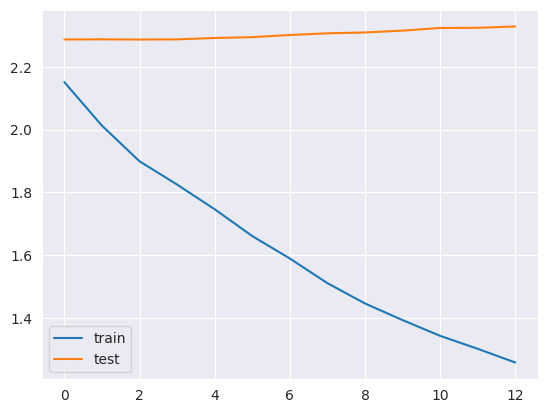

In [127]:
plt.plot(train_results['mlogloss'], label='train')
plt.plot(test_results['mlogloss'], label='test')
plt.legend()
plt.show()

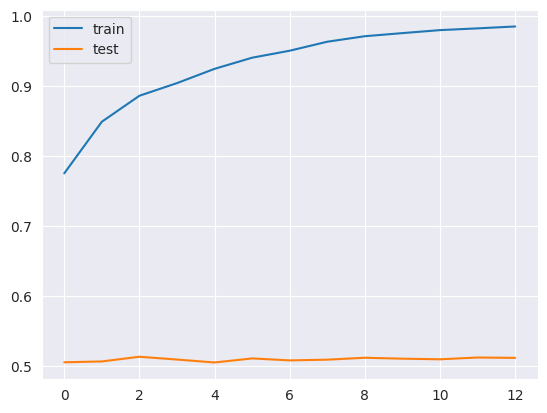

In [128]:
plt.plot(train_results['auc'], label='train')
plt.plot(test_results['auc'], label='test')
plt.legend()
plt.show()

In [129]:
accuracy_score(y_test, test_model.predict(X_test_scaled))

0.09571428571428571

In [130]:
matthews_corrcoef(y_test, test_model.predict(X_test_scaled))

-0.004843288017762267